문제상황 가정 - 어떤 문제가 있는가? :: 커머스 커져가고 사용자 수가 늘어나던 중 최근 고객들이 많이 이탈하고 있다. 그런데, 신규 유입자 수는 역대 최고치를 갱신하고 있기 때문에 서비스를 전면 개편하거나 유통업체를 바꾸는 시도는 하지 않는 것이 좋은 상황이다. 실무에서는 기존 고객들이 이탈하고 있는 이유를 적합하지 않은 광고, 프로모션에 대해 피로감을 느껴서라고 판단하고 있다.

개인화 포로모션을 시도해볼 계획이고 그 전에 실험을 진행하고자 한다.

실험은 50:50으로 A/B 테스트로 진행되며, 기존 일괄 프로모션과 개인화된 프로모션으로 나눠 동시에 실행한다.

따라서 본 분석의 목적은 '개인화'의 기준을 마련하는 것이며, 객관성을 높이기 위해 현업의 경험과 감을 배제하고 머신러닝 군집 분석을 활용한다.

```
목차
___
Step 1. 현실 상황을 가정한다
     1-1. 라이브러리 호출 및 데이터 확인
     1-2. 현실에 맞게 데이터 전처리
     1-3. 컬럼명, 데이터타입 형식 통일
     1-4. 현재 날짜 가정
```

## 1. 현실 상황을 가정한다.

### 1-1. 라이브러리 호출 및 데이터 확인

In [76]:
# 데이터프레임
import pandas as pd

# 시간 계산
import datetime

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 

In [81]:
customer_df_r = pd.read_csv('./data/marketing_campaign.csv', delimiter='\t')
customer_df_r.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


결측치와 데이터 타입을 살펴본다.

In [82]:
customer_df_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

컬럼이 많아서 한번에 다 보여주지 못한다. 가로로 늘어뜨린 barplot으로 결측치를 확인해보자.

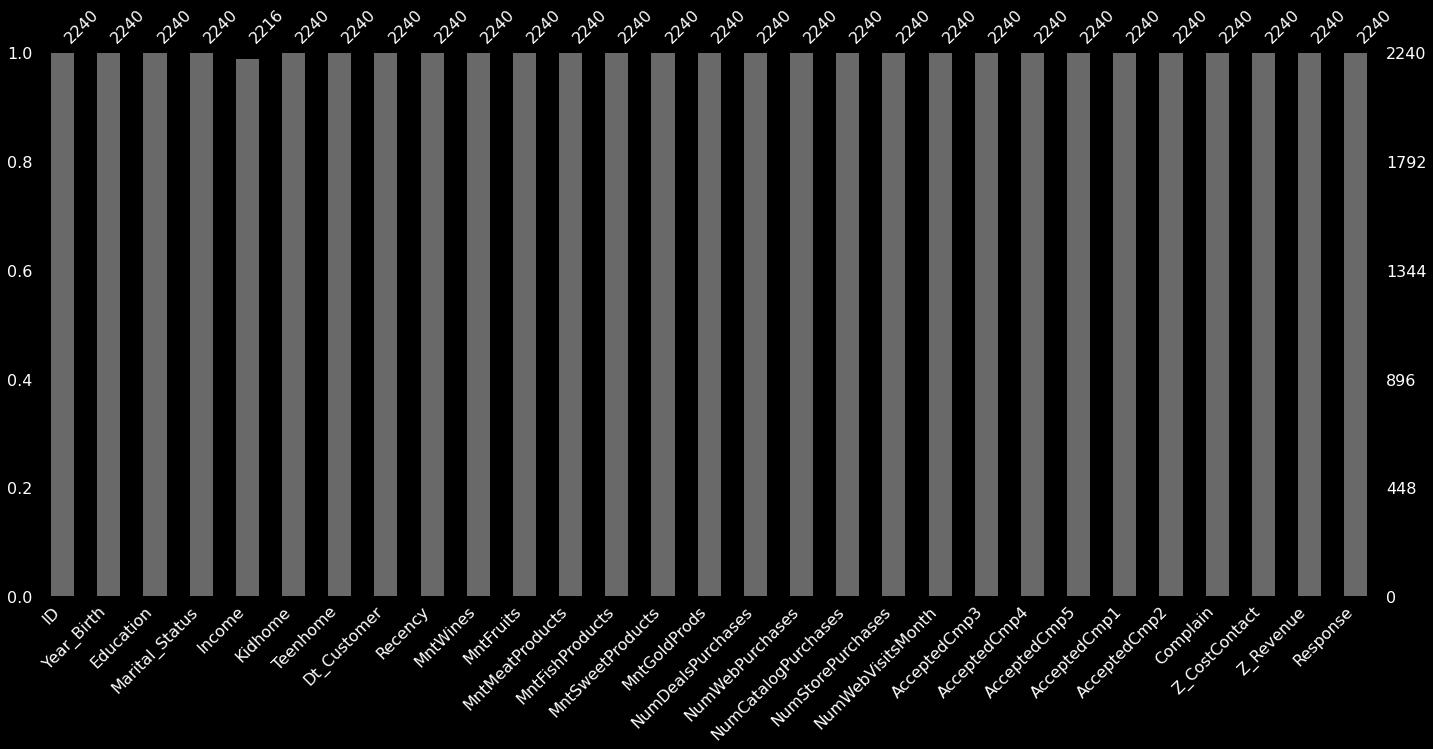

In [83]:
msno.bar(customer_df_r);

Income 컬럼에만 결측가 보인다. 과연 그런지 조건식을 통해 체크해보자.

In [41]:
# 전체 결측치와 Income 컬럼의 결측치 수를 비교. 일치하면 True 반환
customer_df_r.isnull().sum().sum() == customer_df_r['Income'].isnull().sum()

True

전체 중 Income 컬럼에만 결측치가 존재한다. 그래서 저 결측치만 적절히 처리해주고 분류 모델에 우겨넣으면 될 것 같은데, 나는 좀 더 현실적인 상황을 만들어보고 싶다.

### 1-2. 현실에 맞게 데이터 전처리

머신러닝은 이렇게 양질의 데이터와 독립적인 컬럼들이 많을 수록 성능이 좋다. 하지만 실무에서 이렇게 조건이 좋기는 어렵다.

```
----------------------------------------------------------------------------------
People
----------------------------------------------------------------------------------
ID: Customer's unique identifier
Year_Birth: Customer's birth year
Education: Customer's education level
Marital_Status: Customer's marital status
Income: Customer's yearly household income
Kidhome: Number of children in customer's household
Teenhome: Number of teenagers in customer's household
Dt_Customer: Date of customer's enrollment with the company
Recency: Number of days since customer's last purchase
Complain: 1 if customer complained in the last 2 years, 0 otherwise
----------------------------------------------------------------------------------
Products
----------------------------------------------------------------------------------
MntWines: Amount spent on wine in last 2 years
MntFruits: Amount spent on fruits in last 2 years
MntMeatProducts: Amount spent on meat in last 2 years
MntFishProducts: Amount spent on fish in last 2 years
MntSweetProducts: Amount spent on sweets in last 2 years
MntGoldProds: Amount spent on gold in last 2 years
----------------------------------------------------------------------------------
Promotion
----------------------------------------------------------------------------------
NumDealsPurchases: Number of purchases made with a discount
AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
Response: 1 if customer accepted the offer in the last campaign, 0 otherwise
----------------------------------------------------------------------------------
Place
----------------------------------------------------------------------------------
NumWebPurchases: Number of purchases made through the company’s web site
NumCatalogPurchases: Number of purchases made using a catalogue
NumStorePurchases: Number of purchases made directly in stores
NumWebVisitsMonth: Number of visits to company’s web site in the last month
```

여기서 어느 회사에나 있는 데이터는 다음과 같다.

- People 유형의 고객 ID, 출생연도(Year_Birth), 가입일(Dt_Customer), 가장 최근 구매일(Recency, 여기서는 구매 후 오늘까지 날짜로 저장되어 있다.), 클레임 수(Complain) 컬럼
- Promotion 유형의 모든 컬럼(할인 받고 구매한 상품 수와 프로모션에 대한 동의 여부)
- Place 유형의 모든 컬럼(다양한 홍보 채널의 구매 상품 수 관련)

이렇게 상품에 대한 정보, 구매 경로, 고객 가입 정보 등은 어느 업체나 매출 관리를 위해 보유하고 있다. 
반면 아래 컬럼들은 설문과 같은 임의의 특정 방식으로 수집하지 않는다면 보유하기 어렵다.

- People 유형의 교육 수준(Education), 결혼 여부(Marital_Status), 소득 수준(Income), 10세 미만 자녀 수(Kidhome), 10대 자녀 수(Teenhome)
- Products 유형의 모든 컬럼(고객이 1년에 어떤 제품을 얼마나 소비하는지 여부, 이 데이터는 소비는 자사 제품의 구매 내역이 아닌 개인 소비 성향에 대한 답변으로 확보된 것으로 보인다.)

우리는 일반적인 회사에 기본적으로 수집하고 있을 법한 데이터만 분석에 사용할 것이다. 따라서 사용하지 않을 컬럼들을 모두 소거해준다. 추가로, 'Z_CostContact'와 'Z_Revenue'컬럼은 그 의미가 불분명해 역시 소거하겠다.


In [84]:
# 혹시 중요한 컬럼이 있을지 모르니 원본은 남겨두고 다른 변수에 새롭게 할당하여 사용한다.
customer_df = customer_df_r.drop(columns=['Education','Marital_Status','Income','Kidhome','Teenhome',\
                                          'MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds',\
                                          'Z_CostContact','Z_Revenue'], axis=1)
customer_df.head()

,ID,Year_Birth,Dt_Customer,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,5524,1957,04-09-2012,58,3,8,10,4,7,0,0,0,0,0,0,1
1,2174,1954,08-03-2014,38,2,1,1,2,5,0,0,0,0,0,0,0
2,4141,1965,21-08-2013,26,1,8,2,10,4,0,0,0,0,0,0,0
3,6182,1984,10-02-2014,26,2,2,0,4,6,0,0,0,0,0,0,0
4,5324,1981,19-01-2014,94,5,5,3,6,5,0,0,0,0,0,0,0


### 1-3. 컬럼명, 데이터타입 형식 통일

이어서 컬럼명이 복잡하니 이해하기 쉽도록 네이밍을 조금 수정하겠다. 
- 오탈자 방지를 위해 소문자만 사용한다.
- f는 from의 약자, promo는 promotion의 약자로 사용한다.

In [85]:
customer_df.columns = ['id', 'birth', 'enroll', 'day_f_buy', 'buy_f_promo', 'buy_f_web', 'buy_f_catalog', 'buy_f_store','visit_web','promo3','promo4','promo5','prom1','promo2','complain','promo6']
customer_df.head()

,id,birth,enroll,day_f_buy,buy_f_promo,buy_f_web,buy_f_catalog,buy_f_store,visit_web,promo3,promo4,promo5,prom1,promo2,complain,promo6
0,5524,1957,04-09-2012,58,3,8,10,4,7,0,0,0,0,0,0,1
1,2174,1954,08-03-2014,38,2,1,1,2,5,0,0,0,0,0,0,0
2,4141,1965,21-08-2013,26,1,8,2,10,4,0,0,0,0,0,0,0
3,6182,1984,10-02-2014,26,2,2,0,4,6,0,0,0,0,0,0,0
4,5324,1981,19-01-2014,94,5,5,3,6,5,0,0,0,0,0,0,0


In [86]:
# 컬럼별 데이터타입 확인
customer_df.dtypes

id                int64
birth             int64
enroll           object
day_f_buy         int64
buy_f_promo       int64
buy_f_web         int64
buy_f_catalog     int64
buy_f_store       int64
visit_web         int64
promo3            int64
promo4            int64
promo5            int64
prom1             int64
promo2            int64
complain          int64
promo6            int64
dtype: object

enroll 컬럼은 내용에 맞게 datetime으로 변경해준다. 그 후 오늘 날짜(가정)와 비교해서 가입 기간을 계산할 것이다.

In [87]:
customer_df['enroll'] = customer_df['enroll'].astype('datetime64')
customer_df['enroll'] 

0      2012-04-09
1      2014-08-03
2      2013-08-21
3      2014-10-02
4      2014-01-19
          ...    
2235   2013-06-13
2236   2014-10-06
2237   2014-01-25
2238   2014-01-24
2239   2012-10-15
Name: enroll, Length: 2240, dtype: datetime64[ns]

### 1-4. 현재 날짜 가정

In [88]:
customer_df['enroll'].sort_values()

2029   2012-01-08
976    2012-01-08
2194   2012-01-08
724    2012-01-08
1473   2012-01-09
          ...    
153    2014-12-05
815    2014-12-05
216    2014-12-05
50     2014-12-05
2003   2014-12-06
Name: enroll, Length: 2240, dtype: datetime64[ns]

고객 2240명의 가입일을 날짜순으로 나열해보니 가장 최근 가입일이 2014년 말이다. 해당 고객의 데이터를 잠깐 살펴보자.

In [89]:
customer_df.iloc[2003]

id                              6679
birth                           1966
enroll           2014-12-06 00:00:00
day_f_buy                         29
buy_f_promo                        1
buy_f_web                          0
buy_f_catalog                      0
buy_f_store                        3
visit_web                          3
promo3                             0
promo4                             0
promo5                             0
prom1                              0
promo2                             0
complain                           0
promo6                             0
Name: 2003, dtype: object

가장 최근에 가입한 고객은 이번 달에 3번 웹사이트를 방문했으며 오프라인 스토어 상품 3개, 프로모션 상품 1개를 구매했고 구매일로부터 29일 지났다. 그렇다면 우리가 가정할 수 있는 '현 시점'은 2015년 2월 초~중순 정도가 되겠다. 임의로 현재 날짜를 2015년 2월 15일로 설정하고 과거의 시점에서 데이터를 분석한다고 생각해보자.

현 시점을 설정함으로써 고객의 나이와 가입 기간을 확보할 수 있다. 먼저 birth 컬럼 대신 age 컬럼을 만들어보자.

In [91]:
# 고객 나이 계산하기
customer_df['age'] = 2015 - customer_df['birth'] + 1
# 기존 birth 컬럼 제거
customer_df.drop('birth', axis=1, inplace=True)
customer_df['age']

0       59
1       62
2       51
3       32
4       35
        ..
2235    49
2236    70
2237    35
2238    60
2239    62
Name: age, Length: 2240, dtype: int64

다음으로 enroll 컬럼 대신 가입기간을 뜻하는 period 컬럼을 만들어보자. 

In [100]:
# 날짜 차이(기간) 데이터 확보
period = datetime.datetime(2015,2,15) - customer_df['enroll']
period

0      1042 days
1       196 days
2       543 days
3       136 days
4       392 days
          ...   
2235    612 days
2236    132 days
2237    386 days
2238    387 days
2239    853 days
Name: enroll, Length: 2240, dtype: timedelta64[ns]

In [101]:
# 날짜 차이 데이터 -> 타입 변경(timedelta -> int) 후 컬럼 지정
customer_df['period'] = period.dt.days
customer_df.drop('enroll', axis=1, inplace=True)

customer_df['period']

0       1042
1        196
2        543
3        136
4        392
        ... 
2235     612
2236     132
2237     386
2238     387
2239     853
Name: period, Length: 2240, dtype: int64

지금까지 전처리한 데이터를 다시 펼쳐보면 아래와 같다.

In [102]:
customer_df

,id,day_f_buy,buy_f_promo,buy_f_web,buy_f_catalog,buy_f_store,visit_web,promo3,promo4,promo5,prom1,promo2,complain,promo6,age,period
0,5524,58,3,8,10,4,7,0,0,0,0,0,0,1,59,1042
1,2174,38,2,1,1,2,5,0,0,0,0,0,0,0,62,196
2,4141,26,1,8,2,10,4,0,0,0,0,0,0,0,51,543
3,6182,26,2,2,0,4,6,0,0,0,0,0,0,0,32,136
4,5324,94,5,5,3,6,5,0,0,0,0,0,0,0,35,392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,46,2,9,3,4,5,0,0,0,0,0,0,0,49,612
2236,4001,56,7,8,2,5,7,0,0,0,1,0,0,0,70,132
2237,7270,91,1,2,3,13,6,0,1,0,0,0,0,0,35,386
2238,8235,8,2,6,5,10,3,0,0,0,0,0,0,0,60,387


우리는 이제 이 데이터로 가설 검정 과정을 거쳐 유용한 군집 모델을 만들어낼 것이다.